# Petr a vlk: Úvod do posilovaného učení

V tomto tutoriálu se naučíme, jak aplikovat posilované učení na problém hledání cesty. Scénář je inspirován hudební pohádkou [Petr a vlk](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) od ruského skladatele [Sergeje Prokofjeva](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Je to příběh o mladém pionýrovi Petrovi, který se odvážně vydává z domu na lesní mýtinu, aby pronásledoval vlka. Vytrénujeme algoritmy strojového učení, které Petrovi pomohou prozkoumat okolní oblast a vytvořit optimální navigační mapu.

Nejprve si naimportujeme několik užitečných knihoven:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Přehled posilovaného učení

**Posilované učení** (RL) je technika učení, která nám umožňuje naučit se optimální chování **agenta** v určitém **prostředí** prostřednictvím mnoha experimentů. Agent v tomto prostředí by měl mít nějaký **cíl**, definovaný pomocí **funkce odměny**.

## Prostředí

Pro zjednodušení si představme Petrovo prostředí jako čtvercovou desku o rozměrech `width` x `height`. Každé pole na této desce může být:
* **zem**, po které se Petr a ostatní tvorové mohou pohybovat
* **voda**, po které se samozřejmě nemůžete pohybovat
* **strom** nebo **tráva** - místo, kde si můžete odpočinout
* **jablko**, které představuje něco, co by Petr rád našel, aby se mohl najíst
* **vlk**, který je nebezpečný a je třeba se mu vyhnout

Pro práci s prostředím definujeme třídu nazvanou `Board`. Abychom tento notebook příliš nezaplnili, přesunuli jsme veškerý kód pro práci s deskou do samostatného modulu `rlboard`, který nyní importujeme. Můžete se podívat do tohoto modulu, abyste získali více informací o detailech implementace.


In [2]:
from rlboard import *

Pojďme nyní vytvořit náhodnou desku a podívat se, jak vypadá:


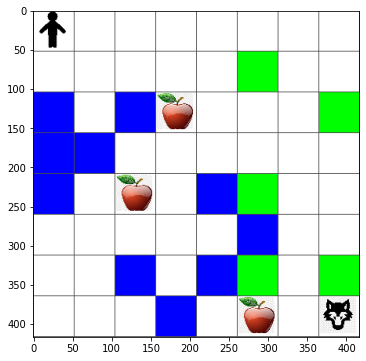

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Akce a pravidla

V našem příkladu by Peterovým cílem bylo najít jablko, zatímco se vyhne vlkovi a dalším překážkám. Aby toho dosáhl, může se v podstatě pohybovat, dokud nenajde jablko. Na každé pozici si tedy může vybrat jednu z následujících akcí: nahoru, dolů, doleva a doprava. Tyto akce definujeme jako slovník a přiřadíme je k dvojicím odpovídajících změn souřadnic. Například pohyb doprava (`R`) by odpovídal dvojici `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Strategie našeho agenta (Petra) je definována takzvanou **politikou**. Podívejme se na nejjednodušší politiku nazvanou **náhodná procházka**.

## Náhodná procházka

Nejprve vyřešme náš problém implementací strategie náhodné procházky.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Pojďme několikrát provést experiment náhodné procházky a podívat se na průměrný počet kroků:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Funkce odměny

Abychom naši politiku učinili chytřejší, musíme pochopit, které tahy jsou „lepší“ než jiné.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Vytvořte Q-Tabulku, nebo vícerozměrné pole. Protože naše hrací plocha má rozměry `width` x `height`, můžeme Q-Tabulku reprezentovat jako numpy pole s tvarem `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Předat Q-Tabulku do funkce pro vykreslení, aby bylo možné vizualizovat tabulku na desce:


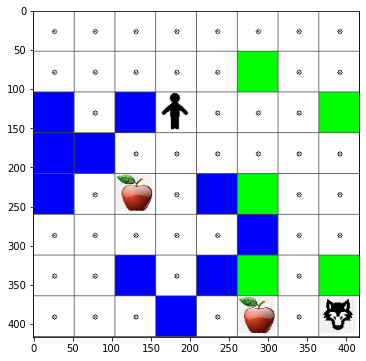

In [9]:
m.plot(Q)

## Podstata Q-Learning: Bellmanova rovnice a učící algoritmus

Napište pseudokód pro náš učící algoritmus:

* Inicializujte Q-Tabulku Q stejnými hodnotami pro všechny stavy a akce
* Nastavte učící rychlost $\alpha\leftarrow 1$
* Opakujte simulaci mnohokrát
   1. Začněte na náhodné pozici
   1. Opakujte
        1. Vyberte akci $a$ ve stavu $s$
        2. Proveďte akci přesunem do nového stavu $s'$
        3. Pokud narazíme na podmínku konce hry nebo je celková odměna příliš malá - ukončete simulaci  
        4. Spočítejte odměnu $r$ v novém stavu
        5. Aktualizujte Q-Funkci podle Bellmanovy rovnice: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Aktualizujte celkovou odměnu a snižte $\alpha$.

## Využití vs. Průzkum

Nejlepší přístup je najít rovnováhu mezi průzkumem a využitím. Jak se o našem prostředí dozvídáme více, budeme pravděpodobněji následovat optimální cestu, avšak občas je dobré zvolit neprozkoumanou cestu.

## Implementace v Pythonu

Nyní jsme připraveni implementovat učící algoritmus. Předtím však potřebujeme funkci, která převede libovolná čísla v Q-Tabulce na vektor pravděpodobností pro odpovídající akce:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Přidáme malé množství `eps` k původnímu vektoru, abychom se vyhnuli dělení nulou v počátečním případě, kdy jsou všechny složky vektoru shodné.

Skutečný učící algoritmus spustíme pro 5000 experimentů, také nazývaných **epochy**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Po provedení tohoto algoritmu by měla být Q-tabulka aktualizována hodnotami, které určují atraktivitu různých akcí v každém kroku. Vizualizujte tabulku zde:


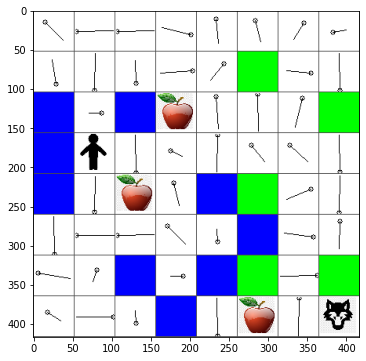

In [12]:
m.plot(Q)

## Kontrola politiky

Protože Q-Tabulka uvádí „atraktivitu“ každé akce v každém stavu, je poměrně snadné ji použít k definování efektivní navigace v našem světě. V nejjednodušším případě můžeme jednoduše vybrat akci odpovídající nejvyšší hodnotě v Q-Tabulce:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Pokud vyzkoušíte výše uvedený kód několikrát, můžete si všimnout, že se někdy prostě "zasekne" a je potřeba stisknout tlačítko STOP v notebooku, abyste jej přerušili.

> **Úkol 1:** Upravte funkci `walk` tak, aby omezila maximální délku cesty na určitý počet kroků (například 100), a sledujte, jak výše uvedený kód tuto hodnotu čas od času vrací.

> **Úkol 2:** Upravte funkci `walk` tak, aby se nevracela na místa, kde již dříve byla. Tím se zabrání tomu, aby se `walk` zacyklila, nicméně agent se stále může ocitnout "uvězněný" na místě, ze kterého není možné uniknout.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


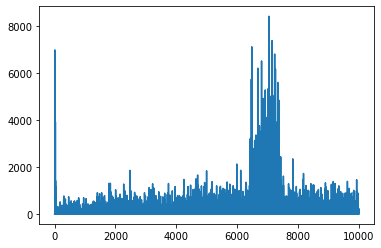

In [15]:
plt.plot(lpath)

Co zde vidíme, je, že zpočátku průměrná délka cesty vzrostla. Pravděpodobně je to způsobeno tím, že když o prostředí nic nevíme, máme tendenci uvíznout ve špatných stavech, jako je voda nebo vlk. Jak se o prostředí dozvídáme více a začneme tyto znalosti využívat, můžeme prostředí prozkoumávat déle, ale stále nevíme dobře, kde se nacházejí jablka.

Jakmile se naučíme dostatek informací, stává se pro agenta snazší dosáhnout cíle a délka cesty začne klesat. Nicméně stále jsme otevřeni průzkumu, takže se často odchýlíme od nejlepší cesty a zkoumáme nové možnosti, což cestu prodlužuje nad optimální délku.

Na tomto grafu také pozorujeme, že v určitém bodě délka cesty náhle vzrostla. To naznačuje stochastickou povahu procesu a fakt, že můžeme v určitém okamžiku "zkazit" koeficienty Q-Tabulky tím, že je přepíšeme novými hodnotami. Ideálně by se tomu mělo zabránit snížením rychlosti učení (tj. ke konci tréninku upravujeme hodnoty Q-Tabulky pouze o malé hodnoty).

Celkově je důležité si uvědomit, že úspěch a kvalita procesu učení významně závisí na parametrech, jako je rychlost učení, pokles rychlosti učení a diskontní faktor. Tyto parametry se často nazývají **hyperparametry**, aby se odlišily od **parametrů**, které optimalizujeme během tréninku (např. koeficienty Q-Tabulky). Proces hledání nejlepších hodnot hyperparametrů se nazývá **optimalizace hyperparametrů** a zaslouží si samostatné téma.


## Cvičení
#### Realističtější svět Petra a vlka

V naší situaci se Petr mohl pohybovat téměř bez toho, aby se unavil nebo měl hlad. V realističtějším světě si však musí čas od času sednout a odpočinout si, a také se najíst. Udělejme náš svět realističtější implementací následujících pravidel:

1. Při pohybu z jednoho místa na druhé Petr ztrácí **energii** a získává **únavu**.
2. Petr může získat více energie tím, že jí jablka.
3. Petr se může zbavit únavy odpočinkem pod stromem nebo na trávě (tj. vstupem na políčko s umístěním stromu nebo trávy - zelené pole).
4. Petr musí najít a zabít vlka.
5. Aby mohl Petr vlka zabít, musí mít určité úrovně energie a únavy, jinak prohraje souboj.

Upravte výše uvedenou funkci odměny podle pravidel hry, spusťte algoritmus posilovaného učení, aby se naučil nejlepší strategii pro výhru ve hře, a porovnejte výsledky náhodné procházky s vaším algoritmem z hlediska počtu vyhraných a prohraných her.

> **Poznámka**: Možná bude nutné upravit hyperparametry, aby vše fungovalo, zejména počet epoch. Protože úspěch ve hře (boj s vlkem) je vzácná událost, můžete očekávat mnohem delší dobu trénování.



---

**Prohlášení**:  
Tento dokument byl přeložen pomocí služby pro automatický překlad [Co-op Translator](https://github.com/Azure/co-op-translator). I když se snažíme o co největší přesnost, mějte prosím na paměti, že automatické překlady mohou obsahovat chyby nebo nepřesnosti. Za autoritativní zdroj by měl být považován původní dokument v jeho původním jazyce. Pro důležité informace doporučujeme profesionální lidský překlad. Neodpovídáme za žádná nedorozumění nebo nesprávné výklady vyplývající z použití tohoto překladu.
